In [1]:
import zipfile
import pandas as pd

# Відкриття головного архіву
with zipfile.ZipFile('toxic_comment_classification.zip', 'r') as z:
    # Виведення списку файлів в архіві
    z.printdir()

    # Спочатку витягаємо вкладені архіви
    z.extractall('extracted_archives')

# Тепер працюємо з витягнутими архівами
nested_archives = ['extracted_archives/train.csv.zip',
                   'extracted_archives/test.csv.zip',
                   'extracted_archives/test_labels.csv.zip',
                   'extracted_archives/sample_submission.csv.zip']

# Функція для розпакування і завантаження CSV
def load_csv_from_zip(zip_path, csv_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(csv_name) as f:
            return pd.read_csv(f)

# Завантаження CSV-файлів
train_data = load_csv_from_zip(nested_archives[0], 'train.csv')
test_data = load_csv_from_zip(nested_archives[1], 'test.csv')
test_labels = load_csv_from_zip(nested_archives[2], 'test_labels.csv')
sample_submission = load_csv_from_zip(nested_archives[3], 'sample_submission.csv')

File Name                                             Modified             Size
sample_submission.csv.zip                      2019-12-11 04:00:40      1459715
test.csv.zip                                   2019-12-11 04:00:42     24577258
test_labels.csv.zip                            2019-12-11 04:00:52      1527605
train.csv.zip                                  2019-12-11 04:00:52     27619914


In [2]:
# Перевірка завантажених даних
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [5]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
import re
from collections import Counter
import spacy

# Завантажте модель Spacy
nlp = spacy.load('en_core_web_sm')

def clean_text_nltk(text):
    # Видалення HTML-тегів
    text = re.sub(r'<.*?>', '', text)
    # Видалення URL-адрес
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'http[^\s]+', '', text)
    # Видалення спеціальних символів, крім пунктуації
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?]', '', text)
    # Видалення повторюваних розділових знаків (більше ніж один)
    text = re.sub(r'([.!?])\1+', r'\1', text)  # Залишити один знак оклику, питання чи крапки
    # Приведення до нижнього регістру
    text = text.lower()
    # Видалення зайвих пробілів
    text = re.sub(r'\s+', ' ', text).strip()

    # Токенізація
    doc = nlp(text)
    seen = set()
    cleaned_words = []
    for token in doc:
        if token.text not in seen:
            seen.add(token.text)
            cleaned_words.append(token.text)

    return ' '.join(cleaned_words)

# Очищення тренувального датасету
train_data['comment_text'] = train_data['comment_text'].apply(clean_text_nltk)

# Перевірка очищених даних
train_data[['comment_text']].head()

,comment_text
0,explanation why the edits made under my userna...
1,daww ! he matches this background colour i m s...
2,"hey man , i m really not trying to edit war . ..."
3,more i ca nt make any real suggestions on impr...
4,"you , sir are my hero . any chance remember wh..."


In [7]:
def selective_clean_text(text):
    # Заміна повторюваних слів, якщо вони йдуть підряд
    cleaned_text = re.sub(r'\b(\w+)( \1)+\b', r'\1', text, flags=re.IGNORECASE)
    return cleaned_text

# Застосування до вашого датасету
train_data['comment_text'] = train_data['comment_text'].apply(selective_clean_text)

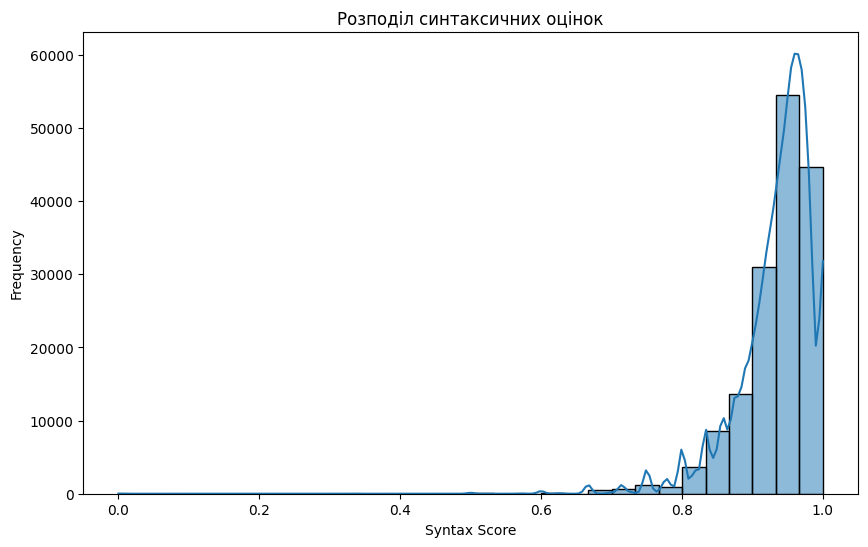

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Функція для оцінки синтаксису
def syntax_score(text):
    doc = nlp(text)
    num_words = sum([1 for token in doc if token.dep_ != 'punct'])
    return num_words / len(doc) if len(doc) > 0 else 0

# Обробка порожніх або недійсних коментарів
train_data['comment_text'].fillna("", inplace=True)

# Додаємо стовпчик з синтаксичними оцінками
train_data['syntax_score'] = train_data['comment_text'].apply(syntax_score)

# Візуалізація розподілу синтаксичних оцінок
plt.figure(figsize=(10,6))
sns.histplot(train_data['syntax_score'], kde=True, bins=30)
plt.title('Розподіл синтаксичних оцінок')
plt.xlabel('Syntax Score')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Аналіз граматичної структури
def analyze_syntax(text):
    doc = nlp(text)
    # Вираховуємо кількість граматичних зв'язків
    return len([token for token in doc if token.dep_ != "punct"])

# Встановлюємо мінімальний поріг граматичних зв'язків
train_data['comment_text'] = train_data['comment_text'].apply(analyze_syntax)
df_cleaned = train_data[train_data['comment_text'] >= 0.7]

In [21]:
# Аналіз граматичної структури (результат зберігаємо в новий стовпець)
train_data['syntax_score'] = train_data['comment_text'].apply(analyze_syntax)

# Фільтруємо коментарі з оцінками, нижчими за поріг
df_cleaned = train_data[train_data['syntax_score'] >= 0.7]

# Перетворюємо стовпець на список оригінальних текстів
texts = df_cleaned['comment_text'].tolist()

from transformers import BertTokenizer

# Завантажуємо токенізатор BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Порахувати кількість токенів для кожного коментаря
token_lengths = [len(tokenizer.tokenize(text)) for text in texts]

# Знаходимо індекс коментаря з найбільшою кількістю токенів
max_token_index = token_lengths.index(max(token_lengths))

# Виводимо коментар з найбільшою кількістю токенів
comment_with_max_tokens = texts[max_token_index]
max_token_count = token_lengths[max_token_index]

print(f"Коментар з найбільшою кількістю токенів ({max_token_count} токенів):\n{comment_with_max_tokens}")


ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'int'>

In [20]:
from transformers import BertTokenizer

# Завантажуємо токенізатор BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Порахувати кількість токенів для кожного коментаря
token_lengths = [len(tokenizer.tokenize(text)) for text in texts]

# Знаходимо індекс коментаря з найбільшою кількістю токенів
max_token_index = token_lengths.index(max(token_lengths))

# Виводимо коментар з найбільшою кількістю токенів
comment_with_max_tokens = texts[max_token_index]
max_token_count = token_lengths[max_token_index]

print(f"Коментар з найбільшою кількістю токенів ({max_token_count} токенів):\n{comment_with_max_tokens}")

TypeError: expected string or bytes-like object, got 'int'

In [10]:
# Токенізуємо текст
tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

print(tokens)

ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.